In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from PrettyShortML import PrettyShortML as psml

In [2]:
# Load in sample data: breast cancer classification (binary classes)
RANDOM_STATE = 42
X, y = datasets.load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X[:, :10])  # to speed up, we just take the first 10 features
y = pd.DataFrame(y)
# Also, Sklearn does not like int columns
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)


Inspect dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    float64
 1   1       569 non-null    float64
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
dtypes: float64(10)
memory usage: 44.6 KB


None



Inspect descriptive statistics:


,0,1,2,3,4,5,6,7,8,9
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440




Top 10 value counts of feature='0':


12.34    4
11.71    3
12.46    3
13.05    3
10.26    3
13.85    3
12.77    3
13.17    3
13.00    3
15.46    3
Name: 0, dtype: int64



Top 10 value counts of feature='1':


20.52    3
16.85    3
16.84    3
19.83    3
14.93    3
17.46    3
18.90    3
15.70    3
18.22    3
20.22    2
Name: 1, dtype: int64



Top 10 value counts of feature='2':


82.61     3
87.76     3
134.70    3
93.97     2
82.69     2
120.20    2
107.10    2
79.19     2
114.20    2
58.79     2
Name: 2, dtype: int64



Top 10 value counts of feature='3':


512.2     3
1075.0    2
582.7     2
399.8     2
641.2     2
394.1     2
372.7     2
477.3     2
758.6     2
1138.0    2
Name: 3, dtype: int64



Top 10 value counts of feature='4':


0.1007    5
0.1150    4
0.1054    4
0.1075    4
0.1063    3
0.1170    3
0.1049    3
0.1044    3
0.1066    3
0.1158    3
Name: 4, dtype: int64



Top 10 value counts of feature='5':


0.11470    3
0.12060    3
0.07698    2
0.05743    2
0.03834    2
0.15160    2
0.11170    2
0.11110    2
0.20870    2
0.10470    2
Name: 5, dtype: int64



Top 10 value counts of feature='6':


0.00000    13
0.12040     3
0.11150     2
0.03344     2
0.11030     2
0.10850     2
0.10100     2
0.01972     2
0.02995     2
0.10070     2
Name: 6, dtype: int64



Top 10 value counts of feature='7':


0.00000    13
0.02864     3
0.14710     2
0.05778     2
0.02272     2
0.02369     2
0.02377     2
0.02594     2
0.05252     2
0.02031     2
Name: 7, dtype: int64



Top 10 value counts of feature='8':


0.1714    4
0.1769    4
0.1893    4
0.1601    4
0.1717    4
0.1861    3
0.1966    3
0.1925    3
0.1506    3
0.1739    3
Name: 8, dtype: int64



Top 10 value counts of feature='9':


0.06113    3
0.05913    3
0.05907    3
0.05667    3
0.06782    3
0.05866    2
0.06020    2
0.05674    2
0.06412    2
0.06019    2
Name: 9, dtype: int64



Amount of NaNs per feature:


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

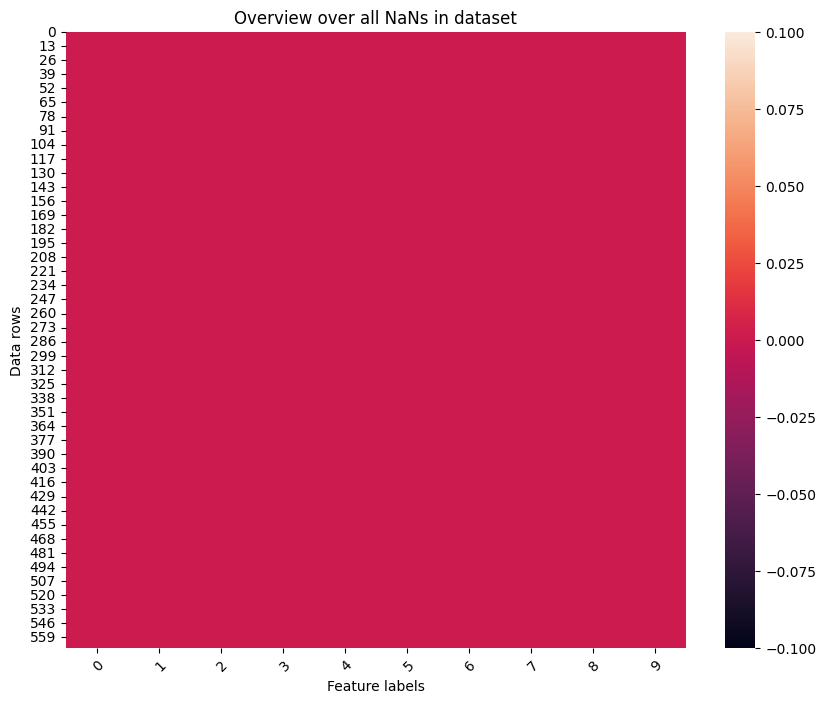

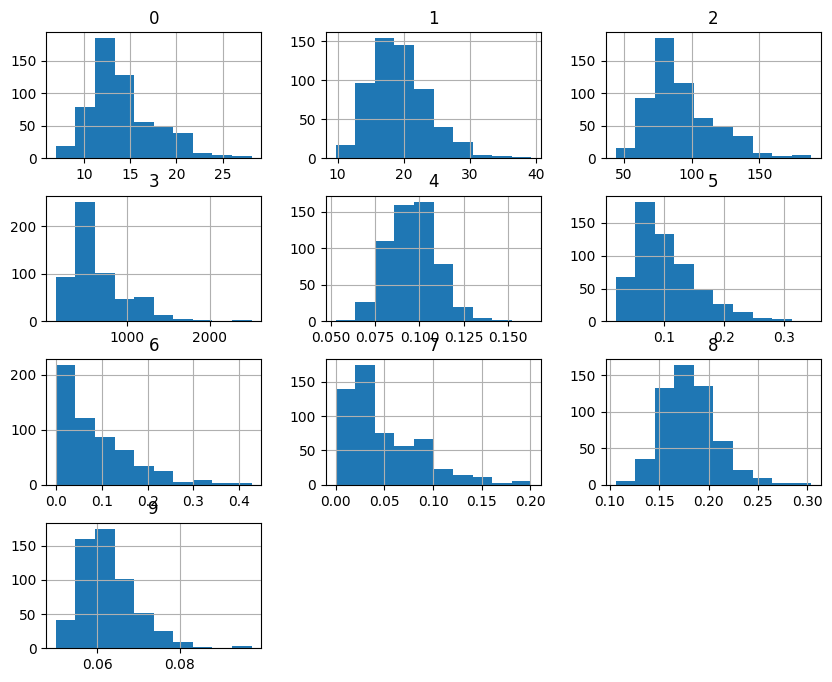

In [3]:
# Do basic EDA
psml.eda_clean_check(X)

In [4]:
# This data is workable, so let's load a class instance after doing a train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)
my_dataset = psml(
    X_train=data_train,
    X_test=data_test,
    y_train=labels_train,
    y_test=labels_test,
)

Starting to plot pairplots. Depending on the dateset size, this may take a while... 
Should it take too long, consider changing the default 'kind' parameter to something else than 'reg'.


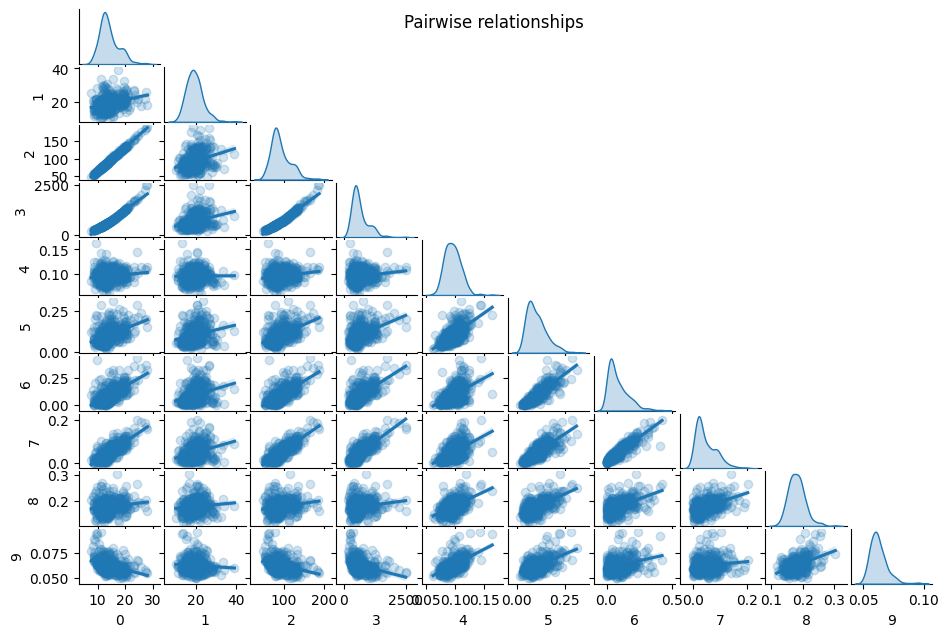

In [5]:
# Plot feature pair plots to inspect distributions and linear relationships
_plotting_ax = my_dataset.plot_eda_pairplot(
    data=my_dataset.X_train, corner=True, dropna=False, plot_hist=False, fig_size=(9, 6)
)

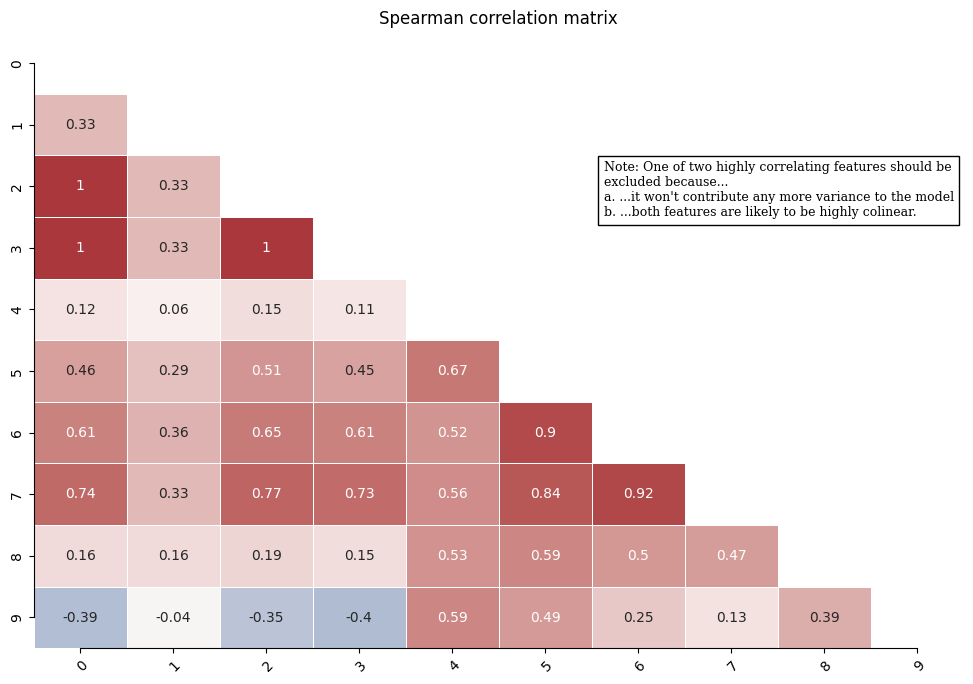

In [6]:
# Plot feature correlation matrix to spot colinearity
_plotting_ax = my_dataset.plot_eda_corr_mat(
    data=my_dataset.X_train, metric="spearman", cmap="vlag", mask=True, annot=True
)

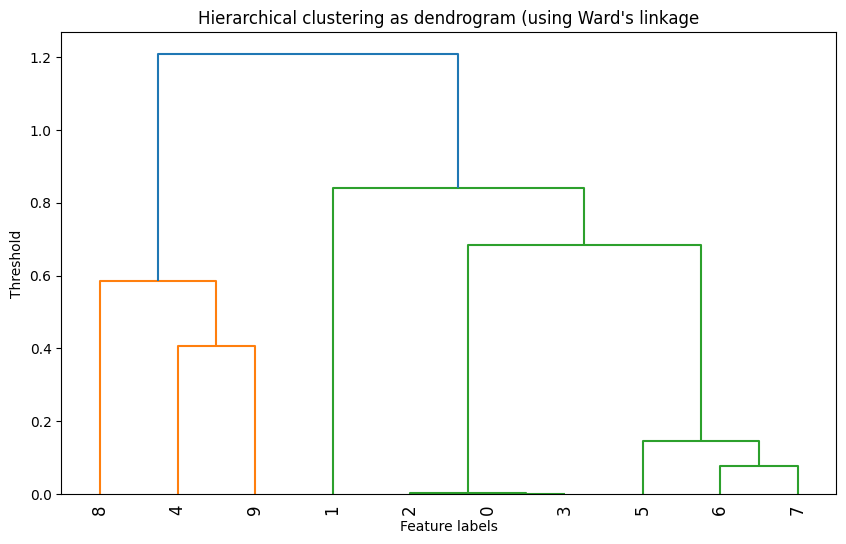

In [7]:
# Normally, we'd do a decent amount of feature cleaning and engineering here.
# For now, let's just do hierarchical clustering on the features' rank-order correlations
# to select features.
# We could run the following to just inspect clustering:
# _plotting_ax, dist_linkage = my_dataset.plot_hierarchical_clustering(
#     data=my_dataset.X_train
# )
# When we know the threshold we want to choose, we can run:
selected_features = my_dataset.cluster_informed_feature_selection(
    data=my_dataset.X_train, cluster_threshold=0.5
)
# Select the features
my_dataset.X_train = my_dataset.X_train.iloc[:, selected_features]
my_dataset.X_test = my_dataset.X_test.iloc[:, selected_features]

In [8]:
# let's train the model now using a CV splitter and some
# params to do gridsearch. Model_train runs SimpleImputer and StandardScaler on default
# for numerical features. We can use the instance instead of passing the data explicitly.
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid = {
    "estimator__solver": ("lbfgs", "liblinear", "newton-cg"),
    "estimator__fit_intercept": (True, False),
}
pipeline, training_score = my_dataset.model_train(
    LogisticRegression(),
    numeric_features=my_dataset.X_train.columns,
    param_grid=param_grid,
    cv=cv_splitter,
)
print(f"The model's performance on training data:\n{training_score:.4f}")

Building and fitting LogisticRegression estimator...
set_config() got an unexpected keyword argument 'transform_output' Couldn't set sklearn's set_config. Is your sklearn version 1.2+ ?


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['0', '1', '4', '5', '8'], dtype='object'))])),
                                       ('estimator', LogisticRegression())]),
             param_grid={'estimator__fit_intercept': (True, False),
                         'estimator__solver': ('lbfgs', 'liblinear',
                                               'newton-cg')})

model_train took 0.241 secs to run.

The model's performance on training data:
0.9197


No model provided, used instance-specific model instead...

 LogisticRegression Model
 Predicted labels
 1    109
0     62
dtype: int64 

Actual labels
 0
1    108
0     63
dtype: int64


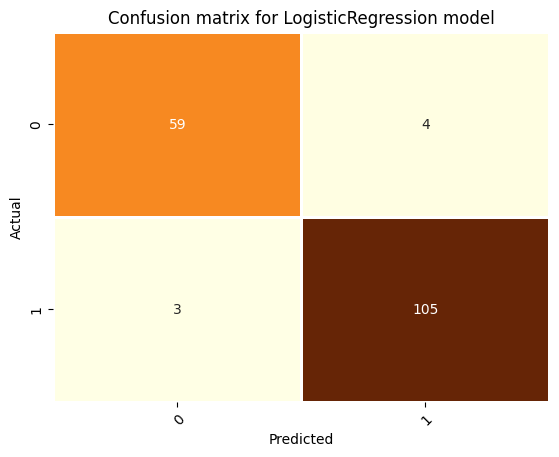

The model's performance on test data:

              precision    recall  f1-score   support

           1     0.9633    0.9722    0.9677       108
           0     0.9516    0.9365    0.9440        63

    accuracy                         0.9591       171
   macro avg     0.9575    0.9544    0.9559       171
weighted avg     0.9590    0.9591    0.9590       171



In [9]:
# Let's evaluate our model on the test data
accuracy, precision, recall, f1score = my_dataset.model_clf_evaluate(
    average="binary", plot_confusion=True, normalize_conmat=False, print_class_report=True
)

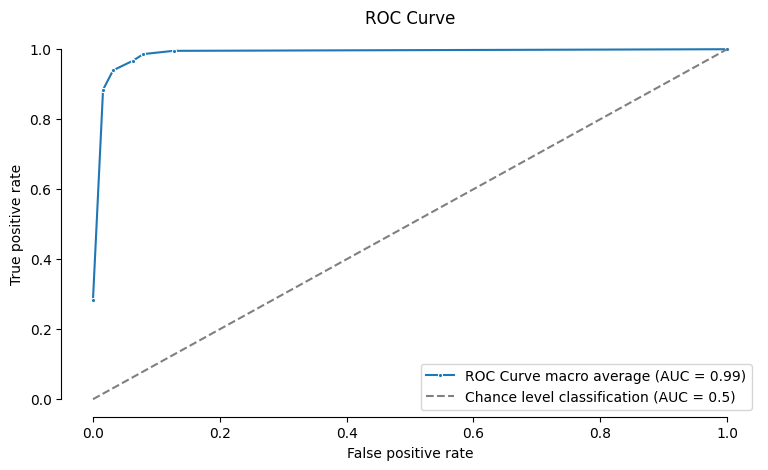

In [10]:
# Let's plot the ROC and precision recall curve
y_test_proba = pipeline.predict_proba(my_dataset.X_test)
# ROC
_plotting_ax, best_threshold = psml.plot_roc_binary(
    y_test=my_dataset.y_test, y_pred_proba=y_test_proba[:, 1], average="macro"
)

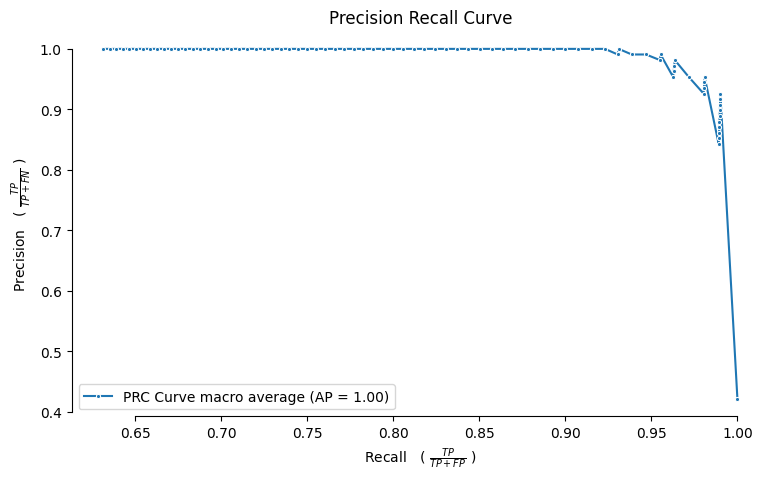

In [11]:
# PRC
_plotting_ax, best_threshold = psml.plot_prc_binary(
    y_test=my_dataset.y_test, y_pred_proba=y_test_proba[:, 1], average="macro"
)